In [12]:
from copy import deepcopy
from pathlib import Path
from pprint import pprint 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.width", 120)

In [13]:
import datetime as dt
from joblib import Memory
import pickle
from shutil import rmtree

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import (
    SelectKBest,
    VarianceThreshold,
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV, 
    StratifiedKFold,
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.pipeline import Pipeline

from sksurv.util import Surv
from sksurv.linear_model import CoxnetSurvivalAnalysis

from lib.pipeline_helpers import fit_and_score_features, p_to_var
from lib.plotting import plot_kaplan_meier

set_config(display="text")  # displays text representation of estimators

In [14]:
import warnings
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning

warnings.simplefilter("ignore", UserWarning) # e.g. suppress wanrings such as UserWarning: all coefficients are zero, consider decreasing alpha.
warnings.simplefilter("ignore", FitFailedWarning)
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [15]:
# local paths
data_dir_proc = Path('data/preprocess')
data_dir_eda = Path('data/eda')
data_dir_wgcna = Path('data/wgcna')
results_dir = Path('results')
results_dir.mkdir(parents=True, exist_ok=True)

# load data

In [16]:
survival = pd.read_parquet(data_dir_proc / 'survival.parquet')
print(survival.head())
print(survival.shape)

                     _PATIENT  OS  OS.time  DSS  DSS.time  DFI  DFI.time  PFI  PFI.time  Redaction
TCGA-69-7978-01  TCGA-69-7978   0    134.0  0.0     134.0  NaN       NaN    0     134.0        NaN
TCGA-62-8399-01  TCGA-62-8399   0   2696.0  0.0    2696.0  0.0    2696.0    0    2696.0        NaN
TCGA-78-7539-01  TCGA-78-7539   0    791.0  0.0     791.0  1.0     688.0    1     688.0        NaN
TCGA-73-4658-01  TCGA-73-4658   1   1600.0  0.0    1600.0  0.0    1600.0    0    1600.0        NaN
TCGA-44-6775-01  TCGA-44-6775   0    705.0  0.0     705.0  1.0     684.0    1     684.0        NaN
(506, 10)


In [17]:
clinical_cat = pd.read_parquet(data_dir_eda / 'clinical_cat.parquet')
clinical_num = pd.read_parquet(data_dir_eda / 'clinical_num.parquet')
clinical = clinical_cat.merge(clinical_num, how='inner', left_index=True, right_index=True)
print(clinical.head())
print(clinical.shape)

                 gender icd_o_3_histology icd_o_3_site other_dx pathologic_M  ... stopped_smoking_year  \
TCGA-69-7978-01    MALE            8255/3        C34.1       No      UNKNOWN  ...                  NaN   
TCGA-62-8399-01    MALE            8255/3        C34.1       No           M0  ...                  NaN   
TCGA-78-7539-01  FEMALE            8255/3        C34.1       No           M0  ...               1981.0   
TCGA-73-4658-01  FEMALE            8140/3        C34.3      Yes           M0  ...                  NaN   
TCGA-44-6775-01  FEMALE            8140/3        C34.1       No      UNKNOWN  ...               2005.0   

                tobacco_smoking_history year_of_initial_pathologic_diagnosis year_of_tobacco_smoking_onset  \
TCGA-69-7978-01     2_former_smoker<15y                               2011.0                           NaN   
TCGA-62-8399-01          4_never_smoked                               2006.0                           NaN   
TCGA-78-7539-01    3_former_smoke

In [18]:
eigengenes = pd.read_parquet(data_dir_wgcna / 'eigengenes.parquet')
print(eigengenes.head())
print(eigengenes.shape)

                 eigengene_1  eigengene_2  eigengene_3  eigengene_4  eigengene_5  eigengene_6  eigengene_7  \
TCGA-69-7978-01    -1.062822   -19.282956    23.728343    15.391015   -25.132080    -2.869945    43.881674   
TCGA-62-8399-01     6.761442    -3.500571    21.603500    10.513065    -8.548311    -7.342347   -21.377836   
TCGA-78-7539-01    -4.423883    -2.219862    -6.606576   -32.970415    22.708065   -25.541518    11.827257   
TCGA-73-4658-01   -38.431645   -21.054591    -6.197557    34.805143     8.004079   -16.302187    24.132778   
TCGA-44-6775-01    -5.612415    -9.650871    20.970369    34.740185    -1.090787    17.312311    22.776034   

                 eigengene_11  eigengene_55  
TCGA-69-7978-01     -4.740974      2.657998  
TCGA-62-8399-01     -5.213105     -0.962454  
TCGA-78-7539-01     -4.044099     -9.953142  
TCGA-73-4658-01     -4.414897      1.939924  
TCGA-44-6775-01     -6.293679     -6.212617  
(506, 9)


In [19]:
event_col = 'OS'
time_col = 'OS.time'
clinical_cat_cols = clinical.select_dtypes(include=['object', 'category', 'bool']).columns.to_list()
clinical_num_cols = clinical.select_dtypes(include=np.number).columns.to_list()
eigengene_cols = eigengenes.columns
# eigengene_cols = eigengenes.columns[:500].to_series()

In [20]:
y = Surv.from_dataframe(event=event_col, time=time_col, data=survival)
print(y.shape)
print(pd.DataFrame.from_records(y).head())
print(f'overall censoring rate: {(~y[event_col]).mean():.3}')

(506,)
      OS  OS.time
0  False    134.0
1  False   2696.0
2  False    791.0
3   True   1600.0
4  False    705.0
overall censoring rate: 0.638


In [21]:
X = clinical.loc[:, clinical_cat_cols + clinical_num_cols]\
    .merge(eigengenes.loc[:, eigengene_cols], how='inner', left_index=True, right_index=True)
print(X.shape)
print(X.head())

(506, 30)
                 gender icd_o_3_histology icd_o_3_site other_dx pathologic_M  ... eigengene_5 eigengene_6 eigengene_7  \
TCGA-69-7978-01    MALE            8255/3        C34.1       No      UNKNOWN  ...  -25.132080   -2.869945   43.881674   
TCGA-62-8399-01    MALE            8255/3        C34.1       No           M0  ...   -8.548311   -7.342347  -21.377836   
TCGA-78-7539-01  FEMALE            8255/3        C34.1       No           M0  ...   22.708065  -25.541518   11.827257   
TCGA-73-4658-01  FEMALE            8140/3        C34.3      Yes           M0  ...    8.004079  -16.302187   24.132778   
TCGA-44-6775-01  FEMALE            8140/3        C34.1       No      UNKNOWN  ...   -1.090787   17.312311   22.776034   

                eigengene_11 eigengene_55  
TCGA-69-7978-01    -4.740974     2.657998  
TCGA-62-8399-01    -5.213105    -0.962454  
TCGA-78-7539-01    -4.044099    -9.953142  
TCGA-73-4658-01    -4.414897     1.939924  
TCGA-44-6775-01    -6.293679    -6.212617  

# pipeline

In [22]:
cachedir = "./.cache"
memory = Memory(location=cachedir, verbose=0)

clinical_cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encode', OneHotEncoder(drop='if_binary', sparse_output=False)),
    ('varthresh', VarianceThreshold(threshold=p_to_var(0.05))),
])

clinical_num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median', add_indicator=True)),
    ('varthresh', VarianceThreshold(threshold=1e-5)),
    ('scale', StandardScaler()),
])

eigengene_pipe = Pipeline([
    ('scale', StandardScaler()),
])

preprocess_pipe = ColumnTransformer([
    ('clinical_cat', clinical_cat_pipe, clinical_cat_cols),
    ('clinical_num', clinical_num_pipe, clinical_num_cols),
    ('eigengenes', eigengene_pipe, eigengene_cols),
])

coxnet_pipe = Pipeline([
    ('preprocess', preprocess_pipe),
    ('select', SelectKBest(fit_and_score_features, k=5)),
    ('coxnet', CoxnetSurvivalAnalysis(max_iter=10000))
], memory=memory)

# params

alpha | l1_ratio | model
----- | -------- | ---
`0`     |          | ordinary regression (OLS?)
`>0`    | 0        | ridge
`>0`    | 1        | lasso

## l1_ratios

In [23]:
# make l1_ratios list and check bounds 
n_l1_ratios = 9
l1_ratios = np.linspace(0.1, 0.9, n_l1_ratios) # 0=Ridge, 1=Lasso
print(len(l1_ratios))
pprint(l1_ratios)

9
array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])


## alphas

In [24]:
# make alphas list and check bounds 
n_alphas = 10
min_alpha = 0.001
max_alpha = 1.0
alphas = [float(x) for x in np.logspace(np.log(min_alpha), np.log(max_alpha), n_alphas, base=np.exp(1))]
# alphas = [float(x) for x in np.logspace(-3, 0.2, n_alphas)]
print(len(alphas))
pprint(alphas)
alphas = [[x] for x in alphas] # the alphas parameter expects a list

10
[0.0010000000000000007,
 0.002154434690031885,
 0.004641588833612782,
 0.009999999999999998,
 0.021544346900318843,
 0.0464158883361278,
 0.09999999999999999,
 0.21544346900318836,
 0.46415888336127786,
 1.0]


In [25]:
params = {
    "preprocess__clinical_cat__impute__strategy": ['constant'],
    "select__k": np.arange(0, 21, 1),
    "coxnet__l1_ratio": l1_ratios,
    "coxnet__alphas": alphas,  
}

# classifier

In [26]:
cv = StratifiedKFold(
    n_splits=3, 
    shuffle=True, 
    random_state=42,
    # random_state=123,
)

cls = RandomizedSearchCV(
    estimator=coxnet_pipe,
    param_distributions=params,
    n_iter=5000, # number of random parameter combinations
    cv=cv,
    n_jobs=-1,
    verbose=0,
    random_state=42,
    error_score=0.5,
    # error_score='raise',
)

# fit

In [27]:
cls.fit(X, y)

memory.clear(warn=False)
rmtree(cachedir)

In [28]:
filename = f'cls_coxnet_wgcna_{dt.datetime.now().strftime("%Y%m%d_%H%M%S")}.sav'
filepath = Path(results_dir) / filename
print(filepath)
pickle.dump(cls, open(filepath, 'wb'))

results/cls_coxnet_wgcna_20251203_230931.sav


# best model

In [29]:
best_model = cls.best_estimator_

print("Best parameters:")
pprint(cls.best_params_)
print("Best score:", cls.best_score_)

Best parameters:
{'coxnet__alphas': [0.09999999999999999],
 'coxnet__l1_ratio': np.float64(0.1),
 'preprocess__clinical_cat__impute__strategy': 'constant',
 'select__k': np.int64(8)}
Best score: 0.7606624905889549


In [30]:
best_coefs = pd.Series(
    best_model.named_steps["coxnet"].coef_.flatten(), 
    # index=best_model.named_steps['preprocess'].get_feature_names_out(),
    index=best_model.named_steps['preprocess'].get_feature_names_out()[best_model.named_steps['select'].get_support()]
)
best_coefs_non_zero = best_coefs[best_coefs != 0]
best_coefs_non_zero = best_coefs_non_zero[best_coefs_non_zero.abs().sort_values(ascending=False).index]
print(f'n non-zero coefs: {len(best_coefs_non_zero)}')
print()
print(best_coefs_non_zero[:20])

n non-zero coefs: 8

clinical_cat__person_neoplasm_cancer_status_TUMOR FREE                              -0.536988
clinical_cat__person_neoplasm_cancer_status_WITH TUMOR                               0.313878
clinical_cat__primary_therapy_outcome_success_Complete/Partial Remission/Response   -0.309699
eigengenes__eigengene_5                                                             -0.195545
clinical_cat__pathologic_stage_Stage I                                              -0.179181
clinical_cat__pathologic_N_N0                                                       -0.163575
clinical_cat__pathologic_stage_Stage III/IV                                          0.153847
clinical_cat__pathologic_N_N1/N2/N3                                                  0.148823
dtype: float64


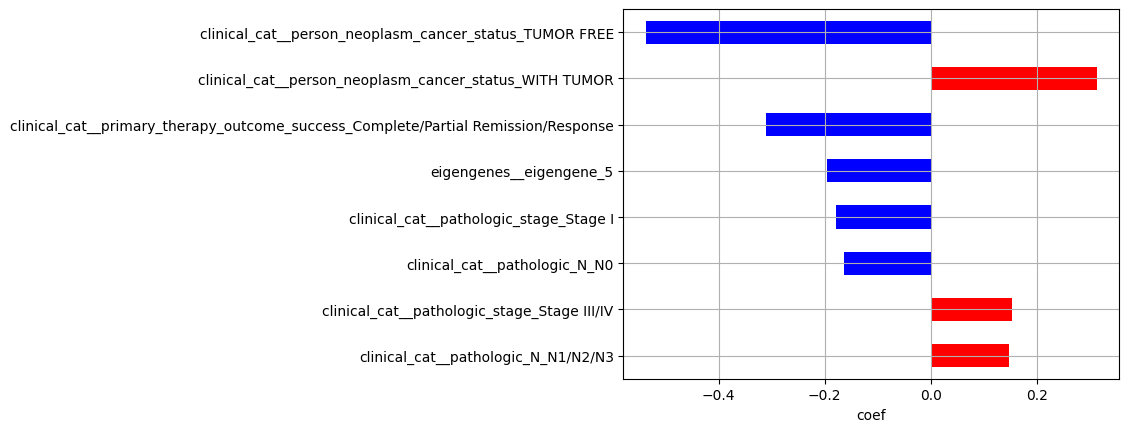

In [31]:
max_n_coefs = 20
if len(best_coefs_non_zero) > 0:
    _ = deepcopy(best_coefs_non_zero)
    if len(_) > max_n_coefs:
        _ = _[:max_n_coefs]
    _ = _[::-1]
    ax = _.plot.barh(
        legend=False, 
        color = (_ > 0).map({True: 'red', False: 'blue'}),
    )
    ax.set_xlabel("coef")
    ax.grid(True)

# cv results

In [32]:
cv_results = pd.DataFrame(cls.cv_results_)

In [33]:
# filter cv_results to get the alphas for the best values of the other params
for param in cls.best_params_:
    if param == 'coxnet__alphas':
        continue
    col = f'param_{param}'
    cv_results = cv_results.loc[cv_results[col] == cls.best_params_[param], :]

In [34]:
cv_results.loc[:, cv_results.columns.str.startswith('param_')].head(5)

,param_select__k,param_preprocess__clinical_cat__impute__strategy,param_coxnet__l1_ratio,param_coxnet__alphas
8,8,constant,0.1,[0.0010000000000000007]
197,8,constant,0.1,[0.002154434690031885]
386,8,constant,0.1,[0.004641588833612782]
575,8,constant,0.1,[0.009999999999999998]
764,8,constant,0.1,[0.021544346900318843]


      alpha      mean       std
0  0.001000  0.754898  0.027284
1  0.002154  0.756283  0.026245
2  0.004642  0.757390  0.025774
3  0.010000  0.758936  0.023810
4  0.021544  0.758819  0.022587
(10, 3)


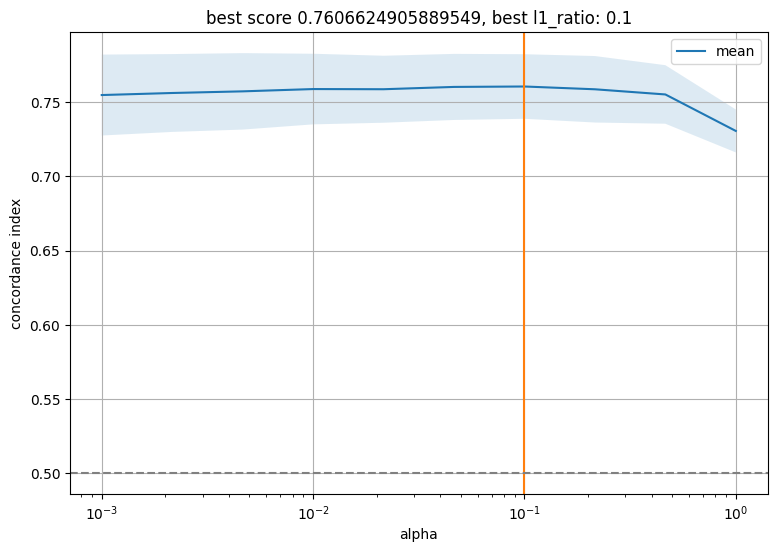

In [35]:
if cv_results.shape[0] > 1: # don't plot if there is only one alpha
    df = pd.DataFrame({
        'alpha': cv_results.param_coxnet__alphas.map(lambda x: x[0]), # 'unlist' each alpha value
        'mean': cv_results.mean_test_score,
        'std': cv_results.std_test_score,
    }).sort_values('alpha').reset_index(drop=True)
    print(df.head())
    print(df.shape)

    best_alpha = cls.best_params_["coxnet__alphas"][0]
    best_l1_ratio = cls.best_params_["coxnet__l1_ratio"]
    best_score = cls.best_score_

    ax = df.plot(x='alpha', y='mean', figsize=(9, 6))
    ax.fill_between(df['alpha'], df['mean'] - df['std'], df['mean'] + df['std'], alpha=0.15)
    ax.set_xscale("log")
    ax.set_ylabel("concordance index")
    ax.set_xlabel("alpha")
    ax.set_title(f'best score {best_score}, best l1_ratio: {best_l1_ratio}')
    ax.axvline(best_alpha, c="C1")
    ax.axhline(0.5, color="grey", linestyle="--")
    ax.grid(True)


# K-M plots

In [46]:
km_df = pd.DataFrame(
    best_model.named_steps['preprocess'].transform(X),
    index=X.index,
    columns=best_model.named_steps['preprocess'].get_feature_names_out(),
)
km_df = km_df.loc[:, best_model.named_steps['select'].get_support()]
km_df = survival[[event_col, time_col]]\
    .merge(km_df[best_coefs_non_zero.index], how='inner', left_index=True, right_index=True)
#print(km_df.head())

## clinical features

In [37]:
clinical_coefs = best_coefs_non_zero[best_coefs_non_zero.index.str.startswith('clinical')]
clinical_coefs.iloc[:3]

clinical_cat__person_neoplasm_cancer_status_TUMOR FREE                              -0.536988
clinical_cat__person_neoplasm_cancer_status_WITH TUMOR                               0.313878
clinical_cat__primary_therapy_outcome_success_Complete/Partial Remission/Response   -0.309699
dtype: float64

<module 'matplotlib.pyplot' from '/Users/darrenkidney/github/analyses/20251103_tcga_luad_survival_analysis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

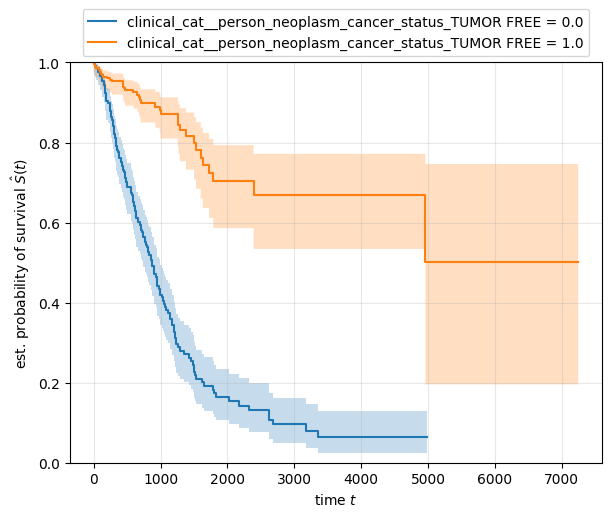

In [38]:
plot_kaplan_meier(km_df, clinical_coefs.index[0])


## eigengenes 

In [39]:
eigengene_coefs = best_coefs_non_zero[best_coefs_non_zero.index.str.startswith('eigengene')]
eigengene_coefs.iloc[:3]

eigengenes__eigengene_5   -0.195545
dtype: float64

<module 'matplotlib.pyplot' from '/Users/darrenkidney/github/analyses/20251103_tcga_luad_survival_analysis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

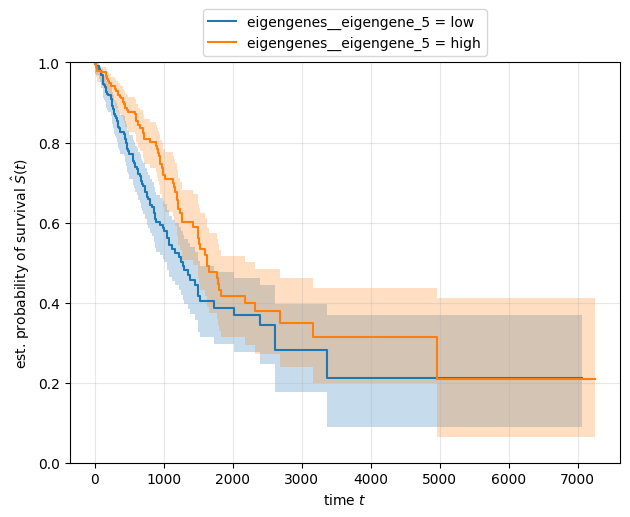

In [40]:
plot_kaplan_meier(km_df, eigengene_coefs.index[0])

## original genes

In [41]:
top_eigengene = eigengene_coefs.index[0].split('__')[-1]
top_eigengene

'eigengene_5'

In [42]:
eigengene_loadings = pd.read_parquet(data_dir_wgcna / 'loadings.parquet')
top_eigengene_loadings = eigengene_loadings.loc[:, top_eigengene]
top_eigengene_loadings = top_eigengene_loadings[top_eigengene_loadings.abs().sort_values(ascending=False).index]
top_eigengene_loadings.head()

SFTPC       0.082239
PGC         0.079457
SCGB3A2     0.077374
C16orf89    0.072236
SFTPA1      0.071654
Name: eigengene_5, dtype: float64

In [43]:
# prepare df for making k-m plots
expression = pd.read_parquet(data_dir_eda / 'expression.parquet')
km_df = survival[[event_col, time_col]]\
    .merge(expression.loc[:,top_eigengene_loadings.index], how='inner', left_index=True, right_index=True)

<module 'matplotlib.pyplot' from '/Users/darrenkidney/github/analyses/20251103_tcga_luad_survival_analysis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

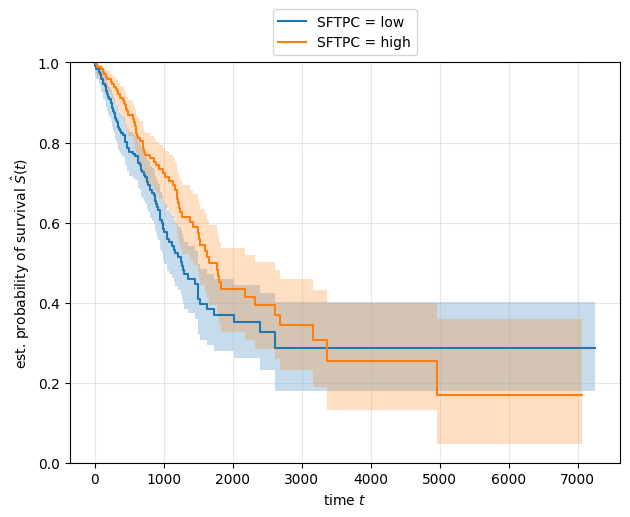

In [44]:
# gene with the highest loading 
plot_kaplan_meier(km_df, top_eigengene_loadings.idxmax())


<module 'matplotlib.pyplot' from '/Users/darrenkidney/github/analyses/20251103_tcga_luad_survival_analysis/.venv/lib/python3.10/site-packages/matplotlib/pyplot.py'>

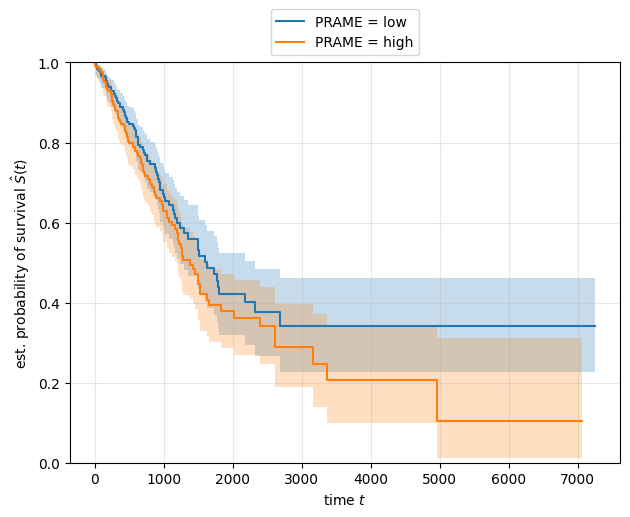

In [45]:
# gene with the lowest loading 
plot_kaplan_meier(km_df, top_eigengene_loadings.idxmin())
